# Image Classification(Potato Disease)

We aim to classify potato plant leafs images to classify its health: whether it is healthy or has a disease(early blight or late blight)

<br>

<img src="potato_plant_types.png">

# Library Import

In [87]:
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import models, layers
import matplotlib.pyplot as plt
import os
# from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

# Data

In [20]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCH = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   'Data',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.
Metal device set to: Apple M1 Pro


2023-03-03 20:44:14.797022: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-03 20:44:14.797095: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
class_names = dataset.class_names
class_names

['early_blight', 'healthy', 'late_blight']

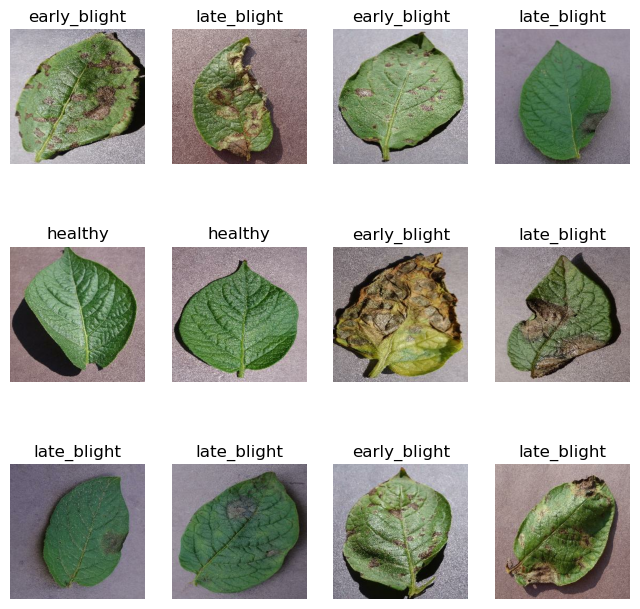

In [19]:
plt.figure(figsize=(8,8))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

## Train/Test Split
We will split the data into:
* 80%: Training
* 20%:
    * 10%: Validation(we use each epoch for validation)
    * 10%: Test(measure accuracy of model)

In [26]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 0)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [30]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Data Processing

## Caching and Prefetching
Cache and prefetch images to increases efficiency

In [31]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

## Data Augmentation
Apply different transformation to our images(image flip, contrast, rotation, zoom) to generate new training samples and increase the variety of images used for training the model

### Scale the Image Data
Scale each pixel value to have value between 0 and 1. We also resize the image to our stipulated size in case during production our supplied images differ from our stipulated size

In [122]:
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
)
train_generator = train_data_generator.flow_from_directory(
    'dataset/train',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=32,
    class_mode='sparse',
    save_to_dir='Augmented_Images'
)

val_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
)
val_generator = train_data_generator.flow_from_directory(
    'dataset/val',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=32,
    class_mode='sparse',
    save_to_dir='Augmented_Images'
)

test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
)
test_generator = train_data_generator.flow_from_directory(
    'dataset/test',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=32,
    class_mode='sparse',
    save_to_dir='Augmented_Images'
)

Found 1506 images belonging to 3 classes.
Found 215 images belonging to 3 classes.
Found 431 images belonging to 3 classes.


# Model Building
We will build a convolutional neural network(CNN)

In [106]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
#model.build(input_shape=input_shape)

In [107]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 64)       

In [108]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [109]:
history = model.fit(
    train_generator,
    steps_per_epoch= 47,
    batch_size=BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=6,
    verbose = 1,
    epochs = 20
)

Epoch 1/20


2023-03-05 14:59:12.400537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.8991 - accuracy: 0.5505

2023-03-05 14:59:49.287857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 41s 824ms/step - loss: 0.8991 - accuracy: 0.5505 - val_loss: 0.8354 - val_accuracy: 0.7031
Epoch 2/20
47/47 [==============================] - 39s 820ms/step - loss: 0.6843 - accuracy: 0.6900 - val_loss: 0.4257 - val_accuracy: 0.8542
Epoch 3/20
47/47 [==============================] - 37s 810ms/step - loss: 0.3622 - accuracy: 0.8541 - val_loss: 0.1886 - val_accuracy: 0.9375
Epoch 4/20
47/47 [==============================] - 37s 806ms/step - loss: 0.2521 - accuracy: 0.9077 - val_loss: 0.1693 - val_accuracy: 0.9427
Epoch 5/20
47/47 [==============================] - 38s 830ms/step - loss: 0.1680 - accuracy: 0.9444 - val_loss: 0.1189 - val_accuracy: 0.9740
Epoch 6/20
47/47 [==============================] - 39s 835ms/step - loss: 0.0975 - accuracy: 0.9668 - val_loss: 0.1132 - val_accuracy: 0.9635
Epoch 7/20
47/47 [==============================] - 38s 833ms/step - loss: 0.2142 - accuracy: 0.9111 - val_loss: 0.1228 - val_accuracy: 0.9531
Epoch 8/20

## Evaluate Model on Test Data

In [110]:
scores = model.evaluate(test_generator)
scores

   1504/Unknown - 1042s 693ms/step - loss: 0.0894 - accuracy: 0.9712

KeyboardInterrupt: 

## Test and Training Accuracy

In [112]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [115]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

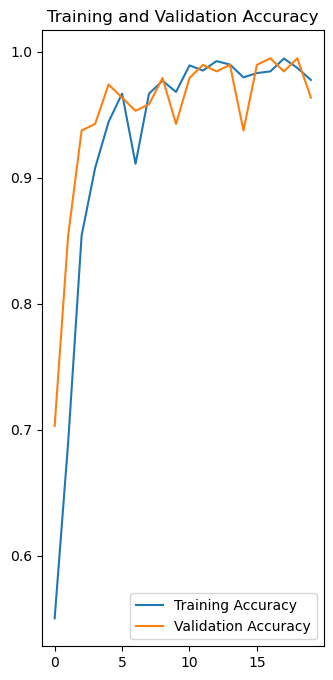

In [116]:
EPOCHS = 20
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Make Predictions

In [80]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [118]:
plt.figure(figsize=(9, 9))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%", fontsize=8)

        plt.axis("off")

FileNotFoundError: [Errno 2] No such file or directory: 'AugmentedImages/_343_3626540.png'

<Figure size 900x900 with 0 Axes>

# Save Model
For the model version number, we will increment the version based on any previously saved models in our models directory

In [123]:
model_version = max([int(i) for i in os.listdir('models') + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/2/assets


## Save Model as h5 file
Save model into one file to upload to Google Cloud Platform

In [124]:
model.save("potato_leaf_classification.h5")